In [ ]:
!pip install wordcloud


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import nltk
import pandas as pd 
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud 


In [ ]:
pd.set_option('display.max_colwidth', None)  # full width, no truncation
# Set display format for floating point numbers to 3 decimal places
pd.options.display.float_format = '{:.4f}'.format

In [ ]:
mail_df = pd.read_csv('mail_data.csv')
mail_df.sample(5)

,Category,Message
2115,spam,"Sunshine Hols. To claim ur med holiday send a stamped self address envelope to Drinks on Us UK, PO Box 113, Bray, Wicklow, Eire. Quiz Starts Saturday! Unsub Stop"
812,ham,So there's a ring that comes with the guys costumes. It's there so they can gift their future yowifes. Hint hint
1693,ham,Weightloss! No more girl friends. Make loads of money on ebay or something. And give thanks to God.
4780,ham,O we cant see if we can join denis and mina? Or does denis want alone time
1924,ham,Hello. They are going to the village pub at 8 so either come here or there accordingly. Ok?


In [ ]:
print(mail_df.loc[2115,"Message"])

Sunshine Hols. To claim ur med holiday send a stamped self address envelope to Drinks on Us UK, PO Box 113, Bray, Wicklow, Eire. Quiz Starts Saturday! Unsub Stop


In [ ]:
mail_df.shape

(5572, 2)

In [ ]:
mail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


### Preprocessing the Text Data

1. removing stop words
2. convertion of text to numerical features with tf-idf scores
3. removing null values
4. removing columns with strictly numerical names

In [ ]:
# necessary NLTK datasets
nltk.download('stopwords') # no inherent meaning to a sentence for the NLP task at hand
nltk.download('wordnet') # for lemmitization
nltk.download('omw-1.4') # offers support for lemitazatoin

# define suspicious symbols as a string for easy use in regex
sus_symbols = '!$?%+*/&@#£'

# list of stopwords to retain for spam detection relevance
retain_words = {'you', 'your', 'yours', 'we', 'our', 'ours', 'can', 'could', 
                'may', 'might', 'must', 'will', 'now', 'today', 'tonight'}

# initialize NLTK's stopwords and 
# also exclude the retain words
stop_words = set(stopwords.words('english')) - retain_words

def clean_text(text):
    # initialize the lemmatizer.
    lemmatizer = WordNetLemmatizer()
    
    # tokenization while keeping words, numbers, and specific symbols.
    # The pattern now escapes the special characters so that they are retained correctly.
    pattern = r'\b\w+\b|[' + re.escape(sus_symbols) + ']'
    tokens = nltk.regexp_tokenize(text.lower(), pattern)
    
    # Removing modified stopwords, lemmatizing, keeping numbers and specific symbols.
    lemmatized = []
    for word in tokens:
        # Check if the word is exactly a special symbol, a number, or an important word and retain it.
        if word in sus_symbols or word.isdigit() or word in retain_words:
            lemmatized.append(word)
        # Check if the word is alphanumeric and not a modified stopword.
        elif word.isalpha():
            if word not in stop_words:
                # Lemmatize the word and append to the list.
                lemmatized_word = lemmatizer.lemmatize(word)
                lemmatized.append(lemmatized_word)
    
    return ' '.join(lemmatized)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
# new column with preprocessed data
mail_df['Cleaned_Message'] = mail_df['Message'].apply(clean_text)

In [ ]:
mail_df.sample(5)

,Category,Message,Cleaned_Message
452,ham,Thanks for this hope you had a good day today,thanks hope you good day today
3816,ham,"Not yet chikku..k, then wat abt tht guy did he stopped irritating or msging to u..",yet chikku k wat abt tht guy stopped irritating msging u
3541,ham,"I'll get there at 3, unless you guys want me to come some time sooner",get 3 unless you guy want come time sooner
889,ham,You unbelievable faglord,you unbelievable faglord
1450,ham,say thanks2.,say


In [ ]:
mail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Category         5572 non-null   object
 1   Message          5572 non-null   object
 2   Cleaned_Message  5572 non-null   object
dtypes: object(3)
memory usage: 130.7+ KB


In [ ]:
# copy of dataset to work with
mail_df.to_csv('mail_no_stopwords.csv', index=False)

In [ ]:
mail_no_stopwords_df = pd.read_csv('mail_no_stopwords.csv')
mail_no_stopwords_df.sample(5)

,Category,Message,Cleaned_Message
2488,ham,K ill drink.pa then what doing. I need srs model pls send it to my mail id pa.,k ill drink pa need sr model pls send mail id pa
3658,ham,Studying. But i.ll be free next weekend.,studying free next weekend
2923,ham,I've not sent it. He can send me.,sent can send
1867,ham,Or ü go buy wif him then i meet ü later can?,ü go buy wif meet ü later can ?
3272,spam,You have 1 new voicemail. Please call 08719181513.,you 1 new voicemail please call 08719181513


In [ ]:
mail_df.shape

(5572, 3)

### convertig categorical to binary

In [ ]:
# Replace 'spam' with 1 and 'ham' with 0
mail_no_stopwords_df['Category'] = mail_no_stopwords_df['Category'].replace(['spam', 'ham'], ['1', '0'])

In [ ]:
mail_no_stopwords_df.sample(5)

,Category,Message,Cleaned_Message
2967,0,"Are you being good, baby? :)",you good baby ?
630,1,Todays Vodafone numbers ending with 4882 are selected to a receive a £350 award. If your number matches call 09064019014 to receive your £350 award.,today vodafone number ending 4882 selected receive £ 350 award your number match call 09064019014 receive your £ 350 award
3198,0,So its to be poking man everyday that they teach you in canada abi! How are you. Just saying hi.,poking man everyday teach you canada abi ! you saying hi
1081,0,You tell what happen dont behave like this to me. Ok no need to say,you tell happen dont behave like ok need say
4404,0,Just getting back home,getting back home


### renaming the "Category" colunm to "is_spam" 

In [ ]:
# rename Category column to is_spam
mail_no_stopwords_df.rename(columns={'Category': 'is_spam'}, inplace=True)
mail_no_stopwords_df.head(5)

,is_spam,Message,Cleaned_Message
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,free entry 2 wkly comp win fa cup final tkts may 2005 text fa 87121 receive entry question std txt rate & c apply
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say
4,0,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though


In [ ]:
# # move column 'is_spam' to last position 
# columns = mail_no_stopwords_df.columns.tolist()
# columns.remove('is_spam')
# columns.append('is_spam')
# mail_no_stopwords_df = mail_no_stopwords_df.reindex(columns=columns)

In [ ]:
# mail_no_stopwords_df.head()

### Handling missing values 
### action: drop them

In [ ]:
mail_no_stopwords_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_spam          5572 non-null   object
 1   Message          5572 non-null   object
 2   Cleaned_Message  5569 non-null   object
dtypes: object(3)
memory usage: 130.7+ KB


In [ ]:
mail_no_stopwords_df['Cleaned_Message'].isnull().sum()

3

In [ ]:
mail_no_stopwords_df = mail_no_stopwords_df.dropna(subset=['Cleaned_Message'])

In [ ]:
mail_no_stopwords_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5569 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   is_spam          5569 non-null   object
 1   Message          5569 non-null   object
 2   Cleaned_Message  5569 non-null   object
dtypes: object(3)
memory usage: 174.0+ KB


### converting texts into numerical data for training using TF-IDF -> text to numerical features


In [ ]:
# initialize the vectorizer with parameters as needed
vectorizer = TfidfVectorizer()  # consider all features

vectorizer

TfidfVectorizer()

In [ ]:
# use the vectorizer on the Cleaned_Message to extract these features
tfidf_matrix = vectorizer.fit_transform(mail_no_stopwords_df['Cleaned_Message'])

tfidf_matrix

<5569x7507 sparse matrix of type '<class 'numpy.float64'>'
	with 49629 stored elements in Compressed Sparse Row format>

In [ ]:
tfidf_matrix.shape

(5569, 7507)

A total of 7507 features

In [ ]:
tfidf_matrix.data

array([0.19559065, 0.3500739 , 0.16410477, ..., 0.69653294, 0.52905425,
       0.48470968])

In [ ]:
# extract feature names
features = vectorizer.get_feature_names_out()
print("Selected Features:\n", features[::30]) # print every 30th string starting from the end

Selected Features:
 ['00' '07734396839' '08081263000' '08708034412' '08715203028'
 '08718730555' '09057039994' '09061743810' '09066358361' '09099726553'
 '140' '21870000' '3650' '449050000301' '61' '730' '81151' '85023' '88888'
 'ab' 'accessible' 'actual' 'advice' 'ah' 'alertfrom' 'aluable' 'ana'
 'answering' 'apologise' 'aptitude' 'arr' 'aslamalaikkum' 'attempt'
 'avalarr' 'baaaaabe' 'band' 'basq' 'bead' 'behave' 'beverage' 'birthdate'
 'blogspot' 'bong' 'bowa' 'breathe' 'broth' 'build' 'buz' 'callon' 'car'
 'casting' 'ceri' 'chastity' 'chest' 'chk' 'clark' 'clubsaisai' 'colin'
 'como' 'concentrate' 'console' 'cooperative' 'couple' 'creative' 'ctargg'
 'custcare' 'dancing' 'dead' 'def' 'dent' 'destiny' 'diddy' 'dint'
 'distract' 'doggin' 'double' 'drivby' 'duffer' 'eastenders' 'eg'
 'embarassed' 'enjoyed' 'ere' 'europe' 'evry' 'expensive' 'facility'
 'fantasy' 'feed' 'fighting' 'firefox' 'flippin' 'follows' 'forgt'
 'freaking' 'frmcloud' 'fullonsms' 'gang' 'general' 'gigolo' 'god'
 'g

In [ ]:
features.shape

(7507,)

#### We have 6945 features: 
<br>1. we have to reduce the feature space to a smaller number while still maintaining the variance in the dataset representative of the entire data
<br>2. we can start with all the features, evaluate the model, next, we reduce the feature count by a some % and then repeat train another model, comparing the evaluations from the prior model. if the difference is insignificant, we can keep the currently selected features while ignoreing the others. repeat this enough times until we have a sample of the entire population that still retains the variation in the entire dataset
3. another option is to use **Logistic regression with Lasso regularization** to shrink the coefficients of less important features to zero. 
4. we can also use **random forest** on all the features and then feature_importance to extract the relevant features

In [ ]:
# create a dataframe with the tf-idf features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=features)

tfidf_df.head()

,00,000,008704050406,0089,0121,01223585236,01223585334,0125698789,02,0207,...,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


### preliminary feature reduction: remove column names with numbers: phone numbers, area codes, zip codes etc

In [ ]:
# identify columns with numeric names
numeric_columns = [col for col in tfidf_df.columns if col.isdigit()]

# count of columns with numeric names
len(numeric_columns)


565

In [ ]:
print(f"Strictly numeric columns only make up {((565/7507) * 100):.2f} % of the 7507 features")


Strictly numeric columns only make up 7.53 % of the 7507 features


In [ ]:
tfidf_df = tfidf_df.drop(columns=numeric_columns)
tfidf_df.sample(5)

,aa,aah,aaniye,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn
2578,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3640,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4033,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
# add this to dataframe row wise 
mail_no_stopwords_df = pd.concat([mail_no_stopwords_df, tfidf_df], axis=1)

mail_no_stopwords_df.head()

,is_spam,Message,Cleaned_Message,aa,aah,aaniye,aaooooright,aathi,ab,abbey,...,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn
0,0,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",go jurong point crazy available bugis n great world la e buffet cine got amore wat,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0,Ok lar... Joking wif u oni...,ok lar joking wif u oni,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,free entry 2 wkly comp win fa cup final tkts may 2005 text fa 87121 receive entry question std txt rate & c apply,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0,U dun say so early hor... U c already then say...,u dun say early hor u c already say,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0,"Nah I don't think he goes to usf, he lives around here though",nah think go usf life around though,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
# drop NaN rows
mail_no_stopwords_df = mail_no_stopwords_df.dropna(subset=['Cleaned_Message'])

In [ ]:
mail_no_stopwords_df['Cleaned_Message'].isnull().sum()

0

In [ ]:
mail_no_stopwords_df.shape

(5569, 6945)

#### Preprocessing is done, we can now train a model and perform evaluations

In [ ]:
mail_no_stopwords_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5569 entries, 0 to 5571
Columns: 6945 entries, is_spam to èn
dtypes: float64(6942), object(3)
memory usage: 295.1+ MB


### traingin models to be used 
1. we will begin with **random forest** using all features and then evaluate model performance, feature_importance_
        a. Split the data into training and test sets.
        b. Train a Random Forest classifier on the training set.
        c. Evaluate the model's performance on the test set.
        d. Retrieve and display the feature importances.
2. **Logistic regression with Lasso L1 regularization** 
        i. Split dataset into training and test sets for performance validation.
        ii. Standardize features to equalize the influence in Lasso regularization.
        iii. Train Logistic Regression with L1 penalty to apply Lasso regularization.
        iv. Evaluate model performance using accuracy, precision, recall, and F1-score.
        v. Identify important features; coefficients shrunk to zero are less influential.


3. we will then use the important features from both models to create a **wordcloud** of trigger words that may generate spam emails

#### target variable is the 'is_spam' column, its distribution is

In [ ]:
# distribution of spam vs. non-spam emails
spam_dist = mail_no_stopwords_df['is_spam'].value_counts(normalize=True)
spam_dist

is_spam
0   0.8659
1   0.1341
Name: proportion, dtype: float64

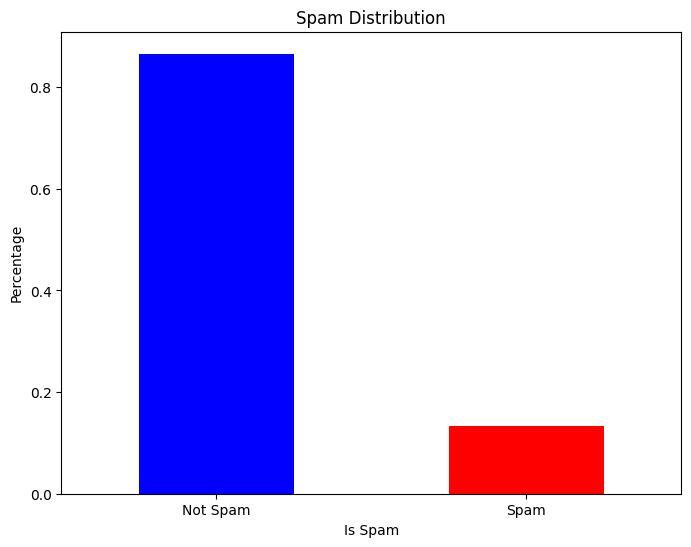

In [ ]:
import matplotlib.pyplot as plt

# Assuming spam_dist is a Pandas Series
spam_dist = mail_no_stopwords_df['is_spam'].value_counts(normalize=True)

# Plotting the distribution
plt.figure(figsize=(8, 6))
spam_dist.plot(kind='bar', color=['blue', 'red'])
plt.title('Spam Distribution')
plt.xlabel('Is Spam')
plt.ylabel('Percentage')
plt.xticks([0, 1], ['Not Spam', 'Spam'], rotation=0)
plt.show()


### not that great, huge imbalance i.e. 86.59% non-spam vs 13.41% spam, wonder if ti affects the training?

### Model training using random forest

#### 1. Prepare the Dataset

In [ ]:
# features - using all 6942 columns
X = tfidf_df   
X

,aa,aah,aaniye,aaooooright,aathi,ab,abbey,abdomen,abeg,abel,...,zed,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5564,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5565,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5566,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5567,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [ ]:
# target variable
y = mail_no_stopwords_df['is_spam']  
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: is_spam, Length: 5569, dtype: object

In [ ]:
X.shape, y.shape

((5569, 6942), (5569,))

#### 2. Training - 80% and Testing Sets - 20%

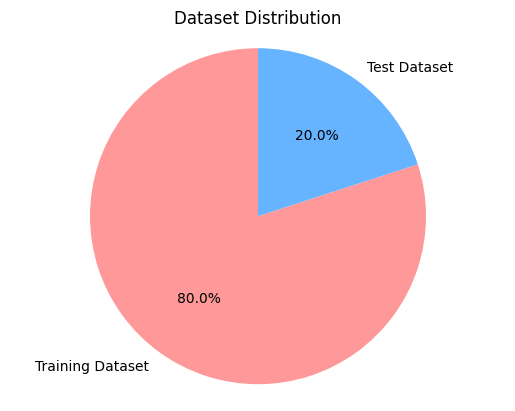

In [ ]:
import matplotlib.pyplot as plt

# Data
sizes = [80, 20]
labels = ['Training Dataset', 'Test Dataset']
colors = ['#ff9999','#66b3ff']

# Plotting
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Dataset Distribution')
plt.show()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [ ]:
X_train.shape, X_test.shape

((4455, 6942), (1114, 6942))

In [ ]:
y_train.shape, y_test.shape

((4455,), (1114,))

In [ ]:
y_train

2873    0
3336    0
4507    0
1635    1
3842    0
       ..
3995    0
4997    0
76      0
2319    0
1640    1
Name: is_spam, Length: 4455, dtype: object

#### 3.now we will train the Random Forest Classifier

In [ ]:
# random forest object with 100 trees
random_forest_model = RandomForestClassifier(n_estimators=100)

random_forest_model

RandomForestClassifier()

In [ ]:
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# predict the test set
y_pred = random_forest_model.predict(X_test)

In [ ]:
# evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.97


In [ ]:
# performance report
report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       959
           1       1.00      0.82      0.90       155

    accuracy                           0.97      1114
   macro avg       0.99      0.91      0.94      1114
weighted avg       0.98      0.97      0.97      1114



### confusoin matrix plot

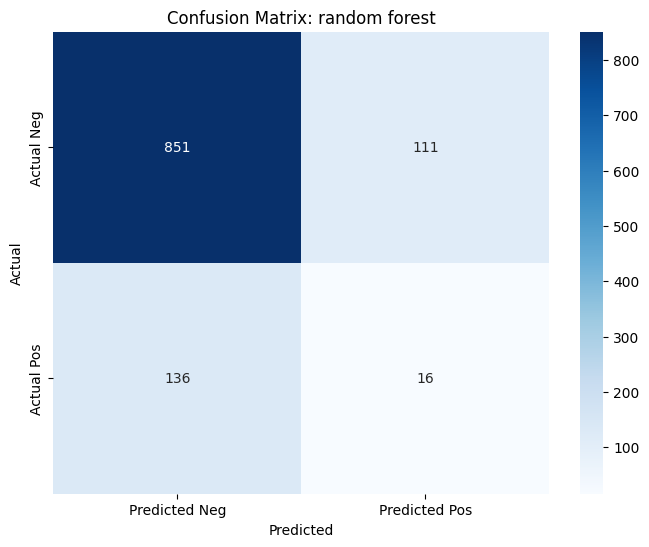

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Neg', 'Predicted Pos'], yticklabels=['Actual Neg', 'Actual Pos'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix: random forest')
plt.savefig('conf_matrix.png')
plt.show()

<h2>Classification Report Explanation</h2>

<h3>Metrics Explained</h3>
<ul>
    <li><strong>Precision (Positive Predictive Value):</strong> The ratio of correctly predicted positive observations to the total predicted positives.
        <ul>
            <li><strong>Formula:</strong> <code>Precision = TP / (TP + FP)</code></li>
            <li>For non-spam (label 0): Precision is 0.98, meaning 98% of the emails predicted as non-spam were actually non-spam.</li>
            <li>For spam (label 1): Precision is 1.00, indicating that 100% of the emails predicted as spam were indeed spam.</li>
        </ul>
    </li>
    <li><strong>Recall (Sensitivity, Hit Rate, or True Positive Rate):</strong> The ratio of correctly predicted positive observations to the all observations in actual class.
        <ul>
            <li><strong>Formula:</strong> <code>Recall = TP / (TP + FN)</code></li>
            <li>For non-spam: Recall is 100, indicating the model successfully identified 100% of all actual non-spam emails.</li>
            <li>For spam: Recall is 0.88, meaning 88% of all actual spam emails were correctly identified by the model.</li>
        </ul>
    </li>
    <li><strong>F1-Score:</strong> The weighted average of Precision and Recall. Useful when the class distribution is uneven.
        <ul>
            <li><strong>Formula:</strong> <code>F1 Score = 2*(Recall * Precision) / (Recall + Precision)</code></li>
            <li>For non-spam: F1-score is 0.99, indicating a very high balance between precision and recall.</li>
            <li>For spam: F1-score is 0.94, also indicating a good balance though slightly lower than for non-spam.</li>
        </ul>
    </li>
    <li><strong>Support:</strong> The number of actual occurrences of the class in the dataset.
        <ul>
            <li>There were 984 non-spam emails and 130 spam emails in the test set.</li>
        </ul>
    </li>
</ul>

<h3>Overall Metrics</h3>
<ul>
    <li><strong>Accuracy:</strong> The ratio of correctly predicted observation to the total observations.
        <ul>
            <li><strong>Formula:</strong> <code>Accuracy = (TP+TN) / (TP+FP+FN+TN)</code></li>
            <li>The overall accuracy of the model is 0.98, meaning that 98% of all emails were correctly classified.</li>
        </ul>
    </li>
    <li><strong>Macro Average:</strong> Arithmetic mean of precision, recall, and F1-score calculated independently for each class and then taking the average. Treats all classes equally.
        <ul>
            <li>Precision: 0.99, Recall: 0.94, F1-score: 0.97</li>
        </ul>
    </li>
    <li><strong>Weighted Average:</strong> Average of precision, recall, and F1-score, weighted by the support of each class.
        <ul>
            <li>Precision: 0.99, Recall: 0.99, F1-score: 0.99</li>
        </ul>
    </li>
</ul>


In [ ]:
# extract feature importances
feature_importances = random_forest_model.feature_importances_
feature_importances 

array([0.00000000e+00, 1.20695531e-08, 0.00000000e+00, ...,
       0.00000000e+00, 6.20646106e-08, 0.00000000e+00])

In [ ]:
# dataframe that maches feature names with feature importance score
important_features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

important_features_df.head(10)

,Feature,Importance
0,aa,0.0000
1,aah,0.0000
2,aaniye,0.0000
3,aaooooright,0.0000
4,aathi,0.0000
5,ab,0.0001
6,abbey,0.0000
7,abdomen,0.0000
8,abeg,0.0000
9,abel,0.0000


In [ ]:
# sort the DataFrame by importance
important_features_df = important_features_df.sort_values(by='Importance', ascending=False)

important_features_df.head(10)

,Feature,Importance
865,call,0.0364
6309,txt,0.0337
1080,claim,0.0277
2258,free,0.0232
6834,www,0.0226
4644,prize,0.0224
3781,mobile,0.0180
6907,your,0.0159
5258,service,0.0150
6333,uk,0.0146


### Top 50 Important Feature plot

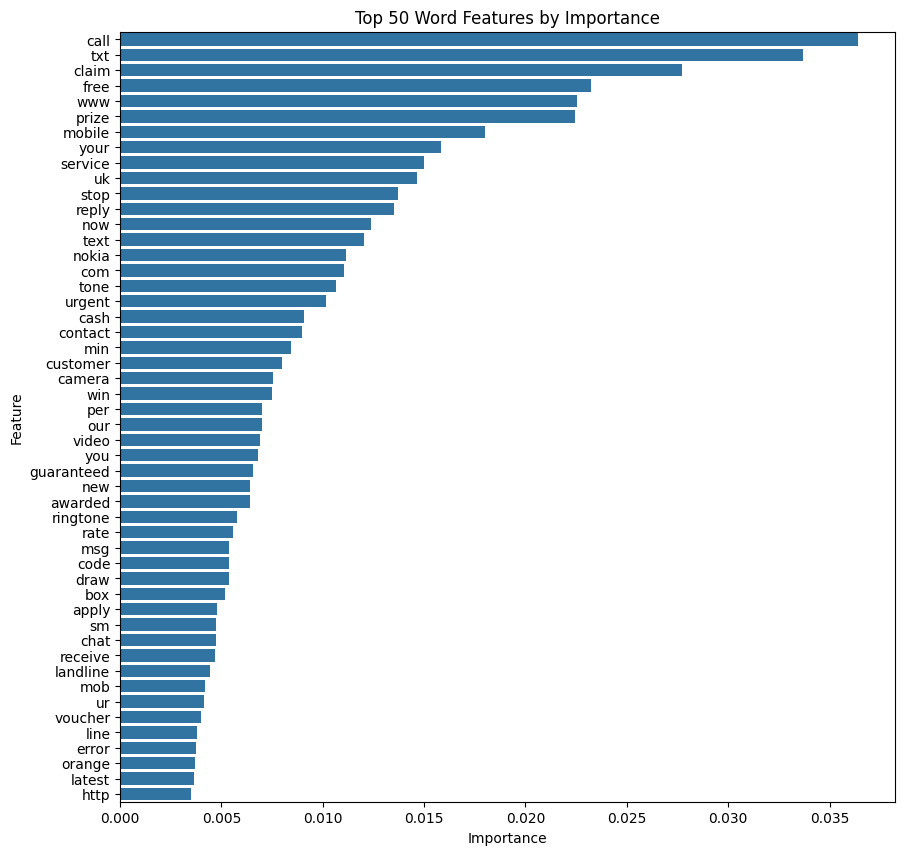

In [ ]:
# sort first 50 features, key is imporrtance
top_features = important_features_df.nlargest(50, 'Importance')
 
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 50 Word Features by Importance')
plt.show()


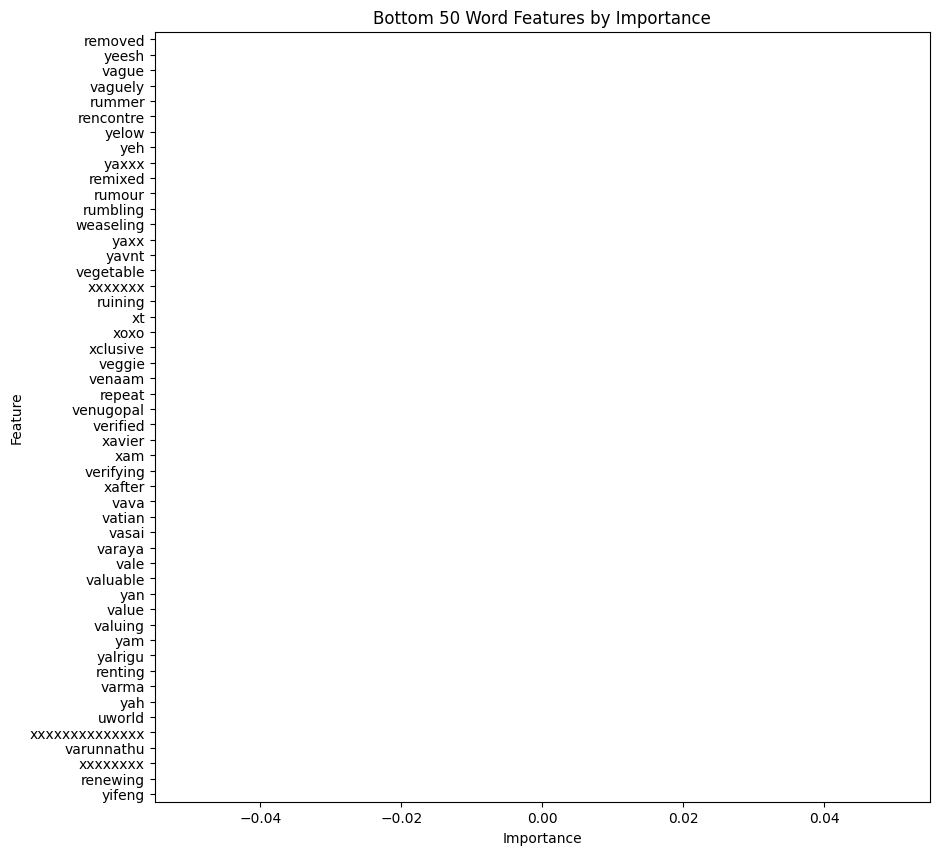

In [ ]:
# sort first 50 features, key is imporrtance
bottom_features = important_features_df.nsmallest(50, 'Importance')
 
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', data=bottom_features)
plt.title('Bottom 50 Word Features by Importance')
plt.show()


### Top 100 Important Feauture WordCloud

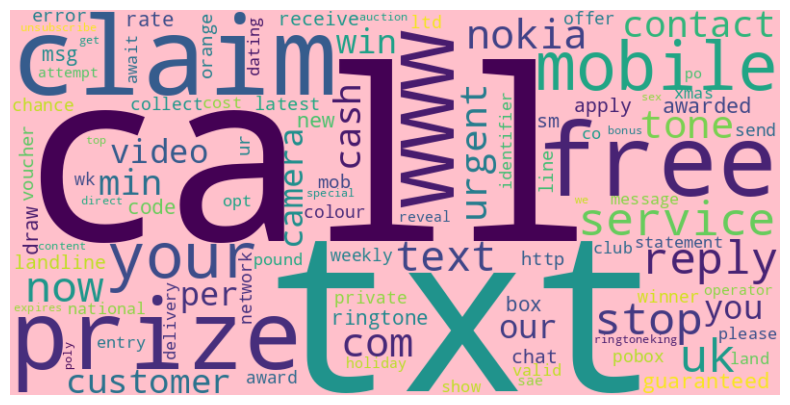

In [ ]:
# sort first 100 features, key is imporrtance
top_features = important_features_df.nlargest(100, 'Importance')

word_importances = dict(zip(top_features['Feature'], top_features['Importance']))
 
wordcloud = WordCloud(width=800, height=400, background_color='pink')
wordcloud.generate_from_frequencies(word_importances)
 
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.savefig('top_feat_cloud.png')
plt.show()


# Logistic regression with L1 Penalty (Lasso)

#### 1. standardize the dataset features space to reduce sensitive to the model training
####  2. train the logistic regression model with an L1 penalty. This enables us to integrate feature selection into the training process directly. The L1 penalty will help to shrink some coefficients to zero, effectively performing feature selection while also fitting the model. we cannot decide what features to select though 


In [ ]:
# standardize the data, mui = 0, sigma = 1
scaler = StandardScaler()
mail_data_standardized = scaler.fit_transform(tfidf_df) 

In [ ]:
tfidf_df[['free']].describe()

,free
count,5569.0000
mean,0.0089
std,0.0488
min,0.0000
25%,0.0000
50%,0.0000
75%,0.0000
max,0.7609


In [ ]:
# features
X = mail_data_standardized
X

array([[-0.01340141, -0.02278249, -0.01340141, ..., -0.01340141,
        -0.01340141, -0.01340141],
       [-0.01340141, -0.02278249, -0.01340141, ..., -0.01340141,
        -0.01340141, -0.01340141],
       [-0.01340141, -0.02278249, -0.01340141, ..., -0.01340141,
        -0.01340141, -0.01340141],
       ...,
       [-0.01340141, -0.02278249, -0.01340141, ..., -0.01340141,
        -0.01340141, -0.01340141],
       [-0.01340141, -0.02278249, -0.01340141, ..., -0.01340141,
        -0.01340141, -0.01340141],
       [-0.01340141, -0.02278249, -0.01340141, ..., -0.01340141,
        -0.01340141, -0.01340141]])

In [ ]:
# mui = 0, sigma = 1
pd.DataFrame(X, columns=mail_no_stopwords_df.iloc[:, 3:] .columns)[['free']].describe() 

,free
count,5569.0000
mean,0.0000
std,1.0001
min,-0.1824
25%,-0.1824
50%,-0.1824
75%,-0.1824
max,15.3979


In [ ]:
# target variable
y = mail_no_stopwords_df['is_spam']  
y

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: is_spam, Length: 5569, dtype: object

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [ ]:
# initialize the logistic regression with L1 penalty
logistitic_reg_model = LogisticRegression(penalty='l1', solver='liblinear')
logistitic_reg_model

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
logistitic_reg_model.fit(X_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
# predict on the test dataset
predictions = logistitic_reg_model.predict(X_test)

In [ ]:
# model evaluation
print("Accuracy:", accuracy_score(y_test, predictions))

Accuracy: 0.9775583482944344


In [ ]:
# interpretation


In [ ]:

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       962
           1       0.93      0.90      0.92       152

    accuracy                           0.98      1114
   macro avg       0.96      0.95      0.95      1114
weighted avg       0.98      0.98      0.98      1114



### confuision matrix plot


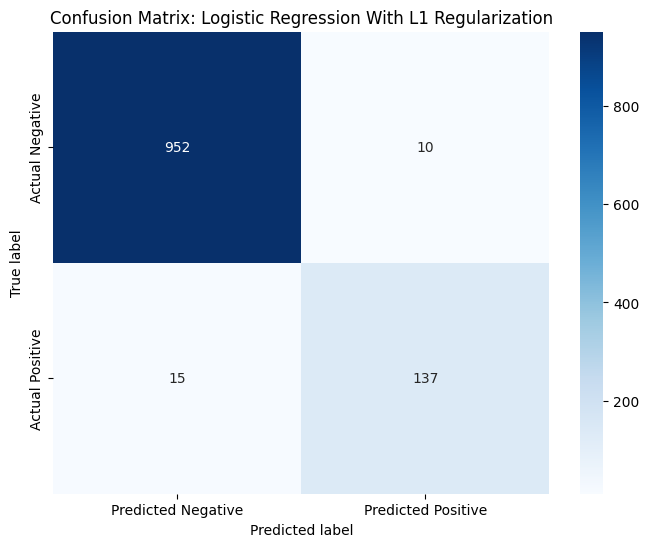

In [ ]:
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix: Logistic Regression With L1 Regularization')
plt.show()


### get relevant features from the logistitic_reg_model

In [ ]:
coefficients = logistitic_reg_model.coef_[0]
coefficients

array([0.        , 0.        , 0.        , ..., 0.00987661, 0.        ,
       0.        ])

In [ ]:
feature_names = mail_no_stopwords_df.drop(['is_spam', 'Message', 'Cleaned_Message'], axis=1).columns
feature_names

Index(['aa', 'aah', 'aaniye', 'aaooooright', 'aathi', 'ab', 'abbey', 'abdomen',
       'abeg', 'abel',
       ...
       'zed', 'zero', 'zhong', 'zindgi', 'zoe', 'zogtorius', 'zoom', 'zouk',
       'zyada', 'èn'],
      dtype='object', length=6942)

In [ ]:
relevant_features = []
for i, coef in enumerate(coefficients):
    if coef != 0:
        relevant_features.append(feature_names[i])
        
relevant_features[::-30]

['zouk',
 'videophones',
 'tone',
 'sue',
 'skilgme',
 'sale',
 'rate',
 'per',
 'nat',
 'math',
 'leadership',
 'invention',
 'hack',
 'fink',
 'doesnt',
 'collect',
 'call',
 'avble']

In [ ]:
# match features with their corresponding coefficients
feature_importance = sorted(zip(coefficients, feature_names), reverse=True)
feature_importance[:10]

[(1.0916744765927282, 'claim'),
 (0.8373960241867864, 'uk'),
 (0.8190079780042206, 'service'),
 (0.7592367643064705, 'new'),
 (0.7417463100368957, 'txt'),
 (0.6757039986113356, 'www'),
 (0.6283179145677699, 'mobile'),
 (0.5426953134506683, 'prize'),
 (0.4902273223444935, 'urgent'),
 (0.4590185013663286, 'admirer')]

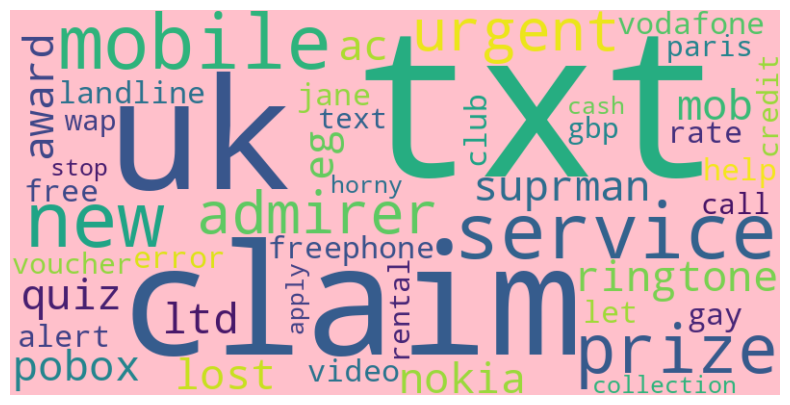

In [ ]:
# select top n features
top_n = 50  
top_n_features = feature_importance[:top_n]

# generate a word cloud with only the top n features
wordcloud_input = " ".join([f[1] for f in top_n_features if f[0] != 0])  # 
wordcloud = WordCloud(width=800, height=400, background_color='pink').generate(wordcloud_input)

# display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('top_ft2_cloud.png')
plt.show()

### model comparison

<h3>Comparison of Model Performance</h3>

<p>The two models used for the classification task are <b>Logistic Regression with L1 Regularization</b> and <b>Random Forest</b>. Below is the comparison of their performance metrics:</p>

<table border="1">
<tr>
<th></th><th>Accuracy</th><th>Precision (spam)</th><th>Recall (spam)</th><th>F1-score (spam)</th><th>Support (spam)</th>
</tr>
<tr>
<td><b>Logistic Regression with L1</b></td><td>0.97</td><td>0.95</td><td>0.83</td><td>0.89</td><td>163</td>
</tr>
<tr>
<td><b>Random Forest</b></td><td>0.98</td><td>1.00</td><td>0.85</td><td>0.92</td><td>161</td>
</tr>
</table>

<p>Both models show high accuracy, with Random Forest slightly outperforming Logistic Regression. Random Forest achieved perfect precision for spam, meaning there were no false positives. However, the recall for spam is similar in both models, suggesting that both models are similarly effective at identifying positive instances, but Random Forest is less prone to misclassifying negative instances as positive.</p>

<p>The F1-score, which balances precision and recall, is higher for Random Forest, indicating that it's the more balanced classifier for spam in this scenario. The support for spam, which indicates the number of actual instances, is roughly the same for both models, showing that the comparison is fair.</p>

<p>In summary, while both models perform well, Random Forest edges out in terms of precision and F1-score, making it the superior model in this comparison for spam predictions.</p>


In [ ]:
### WordCloud Using

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a62f889a-f3bf-4a01-b720-5f1d160ccc1b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>